<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install tensorflow==2.1

### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
#Loading data
data= pd.read_csv("https://raw.githubusercontent.com/yrnigam/Named-Entity-Recognition-NER-using-LSTMs/master/ner_dataset.csv",encoding="latin1")

In [5]:
#Looking for null values
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [6]:
#Filling Null Values
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [7]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [8]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [9]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [10]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [11]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [12]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [13]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [15]:
word2idx

{'Olsson': 1,
 'pro-India': 2,
 'Rakhmonov': 3,
 'contestant': 4,
 'vehicles': 5,
 'costumed': 6,
 'Ball': 7,
 'Remissaninthe': 8,
 'KANU': 9,
 'sown': 10,
 'Anders': 11,
 'trans-Afghan': 12,
 'Anna-Lena': 13,
 'impervious': 14,
 'Tommy': 15,
 'accepting': 16,
 'Farm': 17,
 'Rains': 18,
 'bulletproof': 19,
 'Grenadines': 20,
 'disparaging': 21,
 'motives': 22,
 'Balata': 23,
 'York-based': 24,
 'prudent': 25,
 'extremists': 26,
 '90.41': 27,
 'sentenced': 28,
 'thrived': 29,
 'disbursed': 30,
 'roll': 31,
 'cache': 32,
 'linking': 33,
 'incarceration': 34,
 'ramming': 35,
 'staffing': 36,
 'Torn': 37,
 'Study': 38,
 'solidifies': 39,
 'Humans': 40,
 'musician': 41,
 'low-key': 42,
 'warn': 43,
 'acts': 44,
 'yellow-shirted': 45,
 'adolescents': 46,
 'Science': 47,
 'languages': 48,
 'asleep': 49,
 'fragmentation': 50,
 'Waldron': 51,
 'goblet': 52,
 'anti-Americanism': 53,
 'Danilovich': 54,
 'V-6': 55,
 '809': 56,
 'Schwarzenegger': 57,
 'Zapatistas': 58,
 'Haiti': 59,
 'Fortinet': 60

### Task 5: Padding Input Sentences and Creating Train/Test Splits


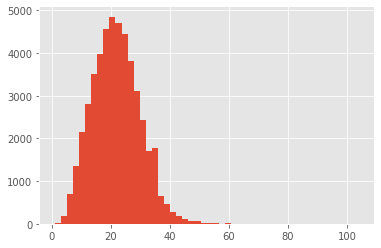

In [16]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

### Task 7: Train the Model

In [22]:
!pip install livelossplot

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

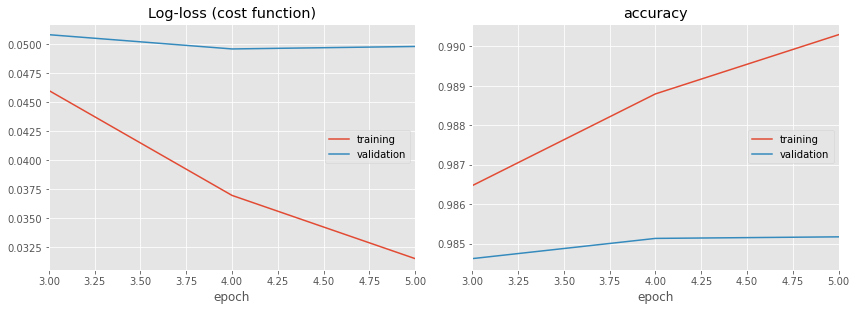

Log-loss (cost function):
training   (min:    0.032, max:    0.268, cur:    0.032)
validation (min:    0.050, max:    0.109, cur:    0.050)

accuracy:
training   (min:    0.944, max:    0.990, cur:    0.990)
validation (min:    0.970, max:    0.985, cur:    0.985)
34530/34530 [==============================] - 115s 3ms/sample - loss: 0.0315 - accuracy: 0.9903 - val_loss: 0.0498 - val_accuracy: 0.9852


In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [25]:
model.evaluate(x_test, np.array(y_test))

4796/4796 [==============================] - 6s 1ms/sample - loss: 0.0508 - accuracy: 0.9850


[0.05077056285985019, 0.98502505]

In [30]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
The            B-org	O
Associated     I-org	I-org
Press          I-org	I-org
says           O    	O
the            O    	O
recommendation O    	O
by             O    	O
Colonel        O    	O
James          B-per	B-per
Daniel         I-per	I-per
will           O    	O
be             O    	O
forwarded      O    	O
to             O    	O
Army           B-org	B-org
officials      O    	O
for            O    	O
a              O    	O
final          O    	O
decision       O    	O
.              O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
communication  O    	O
c